# Predict Rating using Matrix Factorisation and Collaborative Filtering

This notebook will implement Collaborative Filtering and Matrix Factorization to predict ratings made by users on movies.  The data is source from the MovieLens 100k dataset.

In [6]:
import py2neo
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import csv
from pathlib import Path
from time import time


# Some of these keyword arguments are unnecessary, as they are the default values.
graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='password')
print(graph)

<Graph database=<Database uri='bolt://localhost:7687' secure=False user_agent='py2neo/4.2.0 neobolt/1.7.17 Python/3.7.7-final-0 (win32)'> name='data'>


## Data Collection

The Movielens data has been loaded to a NEO4J database  The network structure is 

USER - RATED -> MOVIE

The Movielens dataset included 5 splits of data into Train/Test sets (80%/20%).  This has been loaded in the RATED relationship to allow for cross-validation testing.  Below, the ratings for each user-movie pair are loaded to a dataframe.

In [174]:
query = '''
MATCH (u:USER)-[r:RATED]->(m:MOVIE)
RETURN 
u.id AS id_user
,r.rating AS rating
, r.timestamp AS timestamp
, m.id AS movie_id, 
r.Test_1 as Test_1
, r.Test_2 as Test_2
, r.Test_3 as Test_3,
r.Test_4 as Test_4
, r.Test_5 as Test_5
'''
df_user = pd.DataFrame(graph.run(query).data())

print(df_user.shape)

(100000, 9)


## Matrix Factorisation

The class below will implement matrix factorisation in a Stochastic Gradient Descent solution.  It is based on https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea?gi=904efa4f4b1a.
    
Matrix Factorisation looks to decompose a matrix M into 2 matrices U and V such that
\begin{equation*}
M = U . V
\end{equation*}

Given an original n x m matrix, U will be n x k and V will be k x m so that when matrix multiplied the resultant matrix will be n x m.  By reducing the original sparse matrix to k features, this then leads to a denser representation of the matrix that can be applied to predict unseen data.  So when reducing the dimension and reinflating, the movies that have not been rated by a user will be given a predicted score.

By comparing the actual values to the predictions, the model can evaluate performance and use stochastic gradient descent to move the U and V values to more closely approximate the actual values. 


In [61]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose
      #  self.predictions = np.zeros((self.user_vecs.shape[0], 
      #                          self.item_vecs.shape[0]))

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr) )
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter) )
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            self.predictions = self.predict_all()

            self.train_mse += [get_mse(self.predictions, self.ratings)]
            self.test_mse += [get_mse(self.predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter
            

## Collaborative Filtering

Collaborative Filtering predicts a users' rating for a movie by finding the n closest users to the user in question that have rated a particular movie and then averages their ratings to come up with this users score.

Firstly for each user, their similarity to every other user is calculated.  Cosine similarity is used here to give each user-user pair a similarity score.  Cosine similarity is defined as
\begin{equation*}
sim(x, y) = \frac{\sum_{i=1}^n A_i B_i} {\sqrt{\sum_{i=1}^n A_i^2} \sqrt{\sum_{i=1}^n B_i^2}}
\end{equation*}

So:
1. cosine similarity is calculated for each user-user pair in the training set.
1. Then to predict a movie rating for a user, the n most similar users that **have rated** the movie are chosen and the rating is calcuted usng a weighted average:
\begin{equation*}
r_{xi} = \frac{\sum_{y=1}^n sim(x, y) r_{yi}} {\sum_{y=1}^n sim(x, y)}
\end{equation*}


The code below is based on https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [62]:
from sklearn.metrics import mean_squared_error

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

def predict_k(test, ratings, similarity, kind='user', k=40, type='weighted'):

    pred = np.zeros(ratings.shape)
    # Loop through whole Test matrix looking for non-zero entries.
    # These are then predicted on
    for i in range(ratings.shape[0]):
        
       for j in range(ratings.shape[1]):
          if test[i, j] != 0:  # Find combination of User/Movie that was rated and
                             # so now needs to be predicted
             # For the movie to be rated, find all users that have rated it
             # Then find the k most similar users to user i
             # Sum up their ratings and divide by k
             r2 = ratings[ratings[:,j]!=0,:]
             s2 = similarity[ratings[:,j]!=0,i] # just need 1d array of similarities
             top_k_users = [np.argsort(s2)[:-k-1:-1]]
             if type == 'weighted':
                if sum(s2[top_k_users] != 0):               
                   pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])
             else: # Simple Average
                pred[i, j] = sum(r2[:, j][top_k_users])/k
 
    return pred

In [63]:
from math import sqrt

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

# Training

The dataset provided has train/test splits (80%/20%) that splits the data so that each user has ratings in the training set and in the testing set.  There are 5 training sets provided so each user-movie rating will be 4 training sets and 1 testing set.  This section does cross validation on the 5 sets and saves the Root Mean Squared Error for each run to evaluate performance later.

The steps here are as follows:
- Iterate 5 times, for each training set:
 - split the data into a training set (80%) and testing set (20%)
 - build a matrix of user-movie scores from the training set.  Each matrix element is the rating that user gave to the movie and any movies not rated will be set to 0.
 - For collaborative filtering build the user-user similarity scores
 - Then for each test user-movie pair calculate the rating.  Previous testing indicated that taking the 40 most similar users was a good mark.
 - For Matrix Factorization, train the model on the training set for 100 steps.  Here, the number of latent features was set to 40, after doing hyper-parameter tuning.
 - Calculate and save the RMSE for collaborative filtering
 - Calculate and save the RMSE for matrix factorisation
 

# Hyperparameter Tuning - Random Search
For Matrix Factorisation, the `iter_array` and the `n_factors` parameters are explored in a random way. The set of parameters that produce the lowest MSE will be used in subsequent modelling.

In [6]:
report_dir = Path.cwd().parent.joinpath('reports')

### Matrix Factorisation

In [ ]:
n_users = df_user.id_user.unique().shape[0]
n_items = df_user.movie_id.unique().shape[0]
iter_array_range = range(50, 200)
n_factors_range = range(1, 201)

result_dict = {}
n_searches = 200

for random_iter in range(1, n_searches + 1):
    # Randomly choosing a value for iter_array and n_factors
    iter_array = [np.random.choice(iter_array_range)]
    n_factors = np.random.choice(n_factors_range)
    mf_test_mse = []
    
    print(f'iter_array: {iter_array}')
    print(f'n_factors: {n_factors}')
    start_time = time()
    for i in range(5):
        run = i+1
        print(run)

        train = np.zeros((n_users, n_items))
        test = np.zeros((n_users, n_items))

        for row in df_user[df_user['Test_'+ str(run)] == 'Train'].itertuples():
           train[row[1]-1, row[4]-1] = row[2]

        for row in df_user[df_user['Test_'+ str(run)] != 'Train'].itertuples():
           test[row[1]-1, row[4]-1] = row[2]

        # Matrix Factorisation
        MF_SGD = ExplicitMF(train, n_factors, learning='sgd', verbose=True)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

        mf_test_mse += [np.sqrt(get_mse(MF_SGD.predictions, test))]

    mean_mse = np.mean(mf_test_mse)
    csv_row = iter_array + [n_factors, mean_mse]
    
    print(f'Runtime for {csv_row[:2]} is {(time() - start_time)/60} minutes')
    print(f'Average MSE: {mean_mse}')
    
    filename = report_dir.joinpath(f'MF_cv.csv')
    with open(filename, 'a+', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=',')
        writer.writerow(iter_array + [n_factors, mean_mse])

iter_array: [135]
n_factors: 84
1
Iteration: 135
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
Train mse: 0.7074674405692425
Test mse: 0.8786249502086395
2
Iteration: 135
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
Train mse: 0.7172818198862712
Test mse: 0.8588494251983017
3
Iteration: 135
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current 

### Plot Random CV Results

In [11]:
metric_df = pd.read_csv(report_dir.joinpath('MF_cv.csv'))
metric_df.sort_values(by='mse', ascending=True).head()

,iter_array,n_factors,mse
7,198,162,0.828445
20,195,170,0.829524
18,182,172,0.832172
14,173,99,0.835260
21,160,87,0.841038


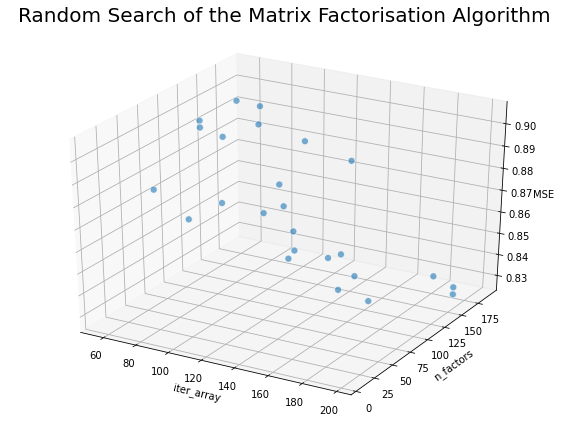

In [35]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

xs = metric_df.iter_array
ys = metric_df.n_factors
zs = metric_df.mse
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('iter_array')
ax.set_ylabel('n_factors')
ax.set_zlabel('MSE')

plt.tight_layout()
plt.title('Random Search of the Matrix Factorisation Algorithm', fontsize=20)

filename = 'mf_random_cv_3d.png'
filepath = report_dir.joinpath('figures', filename)
plt.subplots_adjust(top=0.93)
plt.savefig(filepath, dpi=300, bbox_incehes='tight')

plt.show()


The lowest MSE was achieved at 0.828 using `n_iter=198` and `n_factors=162`.

### Collaborative Filtering (User-User)

In [ ]:
n_users = df_user.id_user.unique().shape[0]
n_items = df_user.movie_id.unique().shape[0]
k_range = range(1, 201)

result_dict = {}
n_searches = 200

for k in k_range:
    # Try different values of k
    print(f'k: {k}')
    
    test_mse_user = []
    test_mse_item = []
    
    start_time = time()
    for i in range(5):
        run = i+1
        print(run)

        train = np.zeros((n_users, n_items))
        test = np.zeros((n_users, n_items))

        for row in df_user[df_user['Test_'+ str(run)] == 'Train'].itertuples():
           train[row[1]-1, row[4]-1] = row[2]

        for row in df_user[df_user['Test_'+ str(run)] != 'Train'].itertuples():
           test[row[1]-1, row[4]-1] = row[2]

        # Colab Filter
        user_similarity = fast_similarity(train, kind='user')
#         item_similarity = fast_similarity(train, kind='item')

        preds_user = predict_k(test, train, user_similarity, kind='user', k=k)
#         preds_item = predict_k(test, train, item_similarity, kind='item', k=k)

        test_mse_user += [np.sqrt(get_mse(preds_user, test))] 
#         test_mse_item += [get_mse(preds_item, test)] 

    mean_mse_user = np.mean(test_mse_user)
#     mean_mse_item = np.mean(test_mse_item)
    csv_row_user = [k, mean_mse_user, 'user-user']
#     csv_row_item = [k, mean_mse_item, 'item-item']
    
    print(f'Runtime for {csv_row_user[:2]} is {(time() - start_time)/60} minutes')
    
    print(f'Average user-user MSE: {mean_mse_user}')
#     print(f'Average item-item MSE: {mean_mse_item}')
    
    filename = report_dir.joinpath(f'CF_cv.csv')
    
    with open(filename, 'a+', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=',')
        writer.writerow(csv_row_user)
#         writer.writerow(csv_row_item)

k: 1
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [1, 1.8119699999999999] is 1.4978740851084391 minutes
Average user-user MSE: 1.8119699999999999
k: 2
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [2, 1.3886643034842039] is 1.5181082924207052 minutes
Average user-user MSE: 1.3886643034842039
k: 3
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [3, 1.2473676192794012] is 1.482606863975525 minutes
Average user-user MSE: 1.2473676192794012
k: 4
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [4, 1.1789703356122359] is 1.495893907546997 minutes
Average user-user MSE: 1.1789703356122359
k: 5
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [5, 1.1381176828547197] is 1.5042638262112935 minutes
Average user-user MSE: 1.1381176828547197
k: 6
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [6, 1.1121790146803527] is 1.4901697754859924 minutes
Average user-user MSE: 1.1121790146803527
k: 7
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [7, 1.0951207063149009] is 1.4889633456865947 minutes
Average user-user MSE: 1.0951207063149009
k: 8
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [8, 1.082871673434724] is 1.5138484517733255 minutes
Average user-user MSE: 1.082871673434724
k: 9
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [9, 1.0733181506989036] is 1.5043886184692383 minutes
Average user-user MSE: 1.0733181506989036
k: 10
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [10, 1.0657576458613853] is 1.550173564751943 minutes
Average user-user MSE: 1.0657576458613853
k: 11
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [11, 1.0595539052981418] is 1.5419034997622172 minutes
Average user-user MSE: 1.0595539052981418
k: 12
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [12, 1.0555623675155223] is 1.5640679637591044 minutes
Average user-user MSE: 1.0555623675155223
k: 13
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [13, 1.0518189412678] is 1.5706490914026896 minutes
Average user-user MSE: 1.0518189412678
k: 14
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [14, 1.0483059584702727] is 1.506518538792928 minutes
Average user-user MSE: 1.0483059584702727
k: 15
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [15, 1.0449003612456829] is 1.511976456642151 minutes
Average user-user MSE: 1.0449003612456829
k: 16
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [16, 1.0429399751441462] is 1.5394740621248881 minutes
Average user-user MSE: 1.0429399751441462
k: 17
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [17, 1.0409738713098646] is 1.5798842906951904 minutes
Average user-user MSE: 1.0409738713098646
k: 18
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [18, 1.0396605384200783] is 1.5170183618863424 minutes
Average user-user MSE: 1.0396605384200783
k: 19
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [19, 1.0380419254372872] is 1.5422279675801596 minutes
Average user-user MSE: 1.0380419254372872
k: 20
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [20, 1.036909905998835] is 1.5308462262153626 minutes
Average user-user MSE: 1.036909905998835
k: 21
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [21, 1.0354989924774975] is 1.496484625339508 minutes
Average user-user MSE: 1.0354989924774975
k: 22
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [22, 1.0351247726848123] is 1.5179335872332256 minutes
Average user-user MSE: 1.0351247726848123
k: 23
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [23, 1.0344245163326082] is 1.512775190671285 minutes
Average user-user MSE: 1.0344245163326082
k: 24
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [24, 1.033895369101252] is 1.512043019135793 minutes
Average user-user MSE: 1.033895369101252
k: 25
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [25, 1.0336976258397432] is 1.5218606154123941 minutes
Average user-user MSE: 1.0336976258397432
k: 26
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [26, 1.0332917558677202] is 1.5141563097635904 minutes
Average user-user MSE: 1.0332917558677202
k: 27
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [27, 1.033085703626444] is 1.5372193455696106 minutes
Average user-user MSE: 1.033085703626444
k: 28
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [28, 1.0326423249403474] is 1.5384506980578105 minutes
Average user-user MSE: 1.0326423249403474
k: 29
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [29, 1.0324932845907497] is 1.5388750235239665 minutes
Average user-user MSE: 1.0324932845907497
k: 30
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [30, 1.0322552256132898] is 1.5796346942583719 minutes
Average user-user MSE: 1.0322552256132898
k: 31
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [31, 1.032189041011833] is 1.5471866885821024 minutes
Average user-user MSE: 1.032189041011833
k: 32
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [32, 1.0320546970554627] is 1.5423693776130676 minutes
Average user-user MSE: 1.0320546970554627
k: 33
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [33, 1.0318217186294292] is 1.5654490868250528 minutes
Average user-user MSE: 1.0318217186294292
k: 34
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [34, 1.0316418810443697] is 1.5766977270444233 minutes
Average user-user MSE: 1.0316418810443697
k: 35
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [35, 1.0316861773424675] is 1.614861536026001 minutes
Average user-user MSE: 1.0316861773424675
k: 36
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [36, 1.0316415503147591] is 1.5935706734657287 minutes
Average user-user MSE: 1.0316415503147591
k: 37
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [37, 1.03171515289947] is 1.5951348423957825 minutes
Average user-user MSE: 1.03171515289947
k: 38
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [38, 1.0316594913302677] is 1.6259853839874268 minutes
Average user-user MSE: 1.0316594913302677
k: 39
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [39, 1.0317489576468957] is 1.641369060675303 minutes
Average user-user MSE: 1.0317489576468957
k: 40
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [40, 1.0320235685636956] is 1.6308026631673178 minutes
Average user-user MSE: 1.0320235685636956
k: 41
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [41, 1.0319691623085767] is 1.6089460253715515 minutes
Average user-user MSE: 1.0319691623085767
k: 42
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [42, 1.0320889857899282] is 1.6118413925170898 minutes
Average user-user MSE: 1.0320889857899282
k: 43
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [43, 1.0319841745365168] is 1.6390727400779723 minutes
Average user-user MSE: 1.0319841745365168
k: 44
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [44, 1.0321140900732673] is 1.6236973921457927 minutes
Average user-user MSE: 1.0321140900732673
k: 45
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [45, 1.0320593234612772] is 1.636817991733551 minutes
Average user-user MSE: 1.0320593234612772
k: 46
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [46, 1.0321741386935437] is 1.635753067334493 minutes
Average user-user MSE: 1.0321741386935437
k: 47
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [47, 1.032307464737416] is 1.6407450596491495 minutes
Average user-user MSE: 1.032307464737416
k: 48
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [48, 1.0324865159996612] is 1.7096928715705872 minutes
Average user-user MSE: 1.0324865159996612
k: 49
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [49, 1.0325690042571831] is 1.641560443242391 minutes
Average user-user MSE: 1.0325690042571831
k: 50
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [50, 1.0327491701684828] is 1.643141218026479 minutes
Average user-user MSE: 1.0327491701684828
k: 51
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [51, 1.0328248019213278] is 1.6710381666819254 minutes
Average user-user MSE: 1.0328248019213278
k: 52
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [52, 1.0328883784904332] is 1.6579175313313803 minutes
Average user-user MSE: 1.0328883784904332
k: 53
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [53, 1.0330160680364013] is 1.6742746472358703 minutes
Average user-user MSE: 1.0330160680364013
k: 54
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [54, 1.0331568939259508] is 1.6707053701082866 minutes
Average user-user MSE: 1.0331568939259508
k: 55
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [55, 1.033137696257239] is 1.654664409160614 minutes
Average user-user MSE: 1.033137696257239
k: 56
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [56, 1.033350399656347] is 1.6988436023394267 minutes
Average user-user MSE: 1.033350399656347
k: 57
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [57, 1.0335140138242962] is 1.7571834166844686 minutes
Average user-user MSE: 1.0335140138242962
k: 58
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [58, 1.0336745185076655] is 1.6934439261754355 minutes
Average user-user MSE: 1.0336745185076655
k: 59
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [59, 1.0338625373027004] is 1.6729517698287963 minutes
Average user-user MSE: 1.0338625373027004
k: 60
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [60, 1.0339160645772476] is 1.6844000816345215 minutes
Average user-user MSE: 1.0339160645772476
k: 61
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [61, 1.034064231950072] is 1.6972461700439454 minutes
Average user-user MSE: 1.034064231950072
k: 62
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [62, 1.0342102941541815] is 1.6944755991299947 minutes
Average user-user MSE: 1.0342102941541815
k: 63
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [63, 1.0342976004892743] is 1.690598479906718 minutes
Average user-user MSE: 1.0342976004892743
k: 64
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [64, 1.034532689065271] is 1.692295749982198 minutes
Average user-user MSE: 1.034532689065271
k: 65
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [65, 1.0347071375836008] is 1.6884768764177958 minutes
Average user-user MSE: 1.0347071375836008
k: 66
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [66, 1.0348158048961091] is 1.7570170243581136 minutes
Average user-user MSE: 1.0348158048961091
k: 67
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [67, 1.034920233797207] is 1.7010983149210612 minutes
Average user-user MSE: 1.034920233797207
k: 68
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [68, 1.0350439730199739] is 1.7244858423868814 minutes
Average user-user MSE: 1.0350439730199739
k: 69
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [69, 1.0351940791159524] is 1.7047507961591084 minutes
Average user-user MSE: 1.0351940791159524
k: 70
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [70, 1.035322440473304] is 1.710949186484019 minutes
Average user-user MSE: 1.035322440473304
k: 71
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [71, 1.0354203271349651] is 1.7306675871213277 minutes
Average user-user MSE: 1.0354203271349651
k: 72
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [72, 1.0355141657932467] is 1.7281216661135355 minutes
Average user-user MSE: 1.0355141657932467
k: 73
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [73, 1.0356009443463035] is 1.7454522291819254 minutes
Average user-user MSE: 1.0356009443463035
k: 74
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [74, 1.0355826688562653] is 1.7270650227864583 minutes
Average user-user MSE: 1.0355826688562653
k: 75
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [75, 1.0357322611812125] is 1.7697133421897888 minutes
Average user-user MSE: 1.0357322611812125
k: 76
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [76, 1.035905305715931] is 1.7610272725423177 minutes
Average user-user MSE: 1.035905305715931
k: 77
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [77, 1.0360039621719697] is 1.7313747922579448 minutes
Average user-user MSE: 1.0360039621719697
k: 78
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [78, 1.0361475666721758] is 1.745818297068278 minutes
Average user-user MSE: 1.0361475666721758
k: 79
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [79, 1.0362474151495082] is 1.743430463473002 minutes
Average user-user MSE: 1.0362474151495082
k: 80
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [80, 1.0363466174690725] is 1.7535891811052957 minutes
Average user-user MSE: 1.0363466174690725
k: 81
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [81, 1.0364371839525832] is 1.754695745309194 minutes
Average user-user MSE: 1.0364371839525832
k: 82
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [82, 1.0364835670826098] is 1.7314995884895326 minutes
Average user-user MSE: 1.0364835670826098
k: 83
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [83, 1.0366118227176453] is 1.81777796347936 minutes
Average user-user MSE: 1.0366118227176453
k: 84
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [84, 1.036721884504347] is 1.7874515771865844 minutes
Average user-user MSE: 1.036721884504347
k: 85
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [85, 1.03681570266396] is 1.8650854706764222 minutes
Average user-user MSE: 1.03681570266396
k: 86
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [86, 1.036852691502658] is 1.8172371625900268 minutes
Average user-user MSE: 1.036852691502658
k: 87
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [87, 1.0369681128419654] is 1.8542611400286357 minutes
Average user-user MSE: 1.0369681128419654
k: 88
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [88, 1.0370762407691476] is 1.8514489889144898 minutes
Average user-user MSE: 1.0370762407691476
k: 89
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [89, 1.0372019953072957] is 1.8182605147361754 minutes
Average user-user MSE: 1.0372019953072957
k: 90
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [90, 1.037348883952488] is 1.8759181062380472 minutes
Average user-user MSE: 1.037348883952488
k: 91
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [91, 1.0374565092901626] is 1.8732889731725058 minutes
Average user-user MSE: 1.0374565092901626
k: 92
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [92, 1.0375248792671161] is 1.9405145565668742 minutes
Average user-user MSE: 1.0375248792671161
k: 93
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [93, 1.0376790552043826] is 1.8503174742062887 minutes
Average user-user MSE: 1.0376790552043826
k: 94
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [94, 1.0377409366211587] is 1.8478131612141928 minutes
Average user-user MSE: 1.0377409366211587
k: 95
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [95, 1.037808943352148] is 1.885086758931478 minutes
Average user-user MSE: 1.037808943352148
k: 96
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [96, 1.0378340577985754] is 1.8612665812174478 minutes
Average user-user MSE: 1.0378340577985754
k: 97
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [97, 1.037940787997614] is 1.88142595688502 minutes
Average user-user MSE: 1.037940787997614
k: 98
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [98, 1.0380434950897688] is 1.8616825819015503 minutes
Average user-user MSE: 1.0380434950897688
k: 99
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [99, 1.0381849619673411] is 1.889454734325409 minutes
Average user-user MSE: 1.0381849619673411
k: 100
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [100, 1.038306545915547] is 1.8861766695976256 minutes
Average user-user MSE: 1.038306545915547
k: 101
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [101, 1.0384207439011715] is 1.870443546772003 minutes
Average user-user MSE: 1.0384207439011715
k: 102
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [102, 1.0384902330019044] is 1.8768166542053222 minutes
Average user-user MSE: 1.0384902330019044
k: 103
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [103, 1.038589015873647] is 1.8842547337214153 minutes
Average user-user MSE: 1.038589015873647
k: 104
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [104, 1.0386950365378778] is 1.8739046613375345 minutes
Average user-user MSE: 1.0386950365378778
k: 105
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [105, 1.038816479495025] is 1.8642285188039145 minutes
Average user-user MSE: 1.038816479495025
k: 106
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [106, 1.038894306300367] is 1.8601433753967285 minutes
Average user-user MSE: 1.038894306300367
k: 107
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [107, 1.038993260059675] is 1.924964467684428 minutes
Average user-user MSE: 1.038993260059675
k: 108
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [108, 1.0390796617424507] is 1.9199475248654683 minutes
Average user-user MSE: 1.0390796617424507
k: 109
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [109, 1.0391548140323297] is 1.9168275237083434 minutes
Average user-user MSE: 1.0391548140323297
k: 110
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [110, 1.0392280589744902] is 1.853121316432953 minutes
Average user-user MSE: 1.0392280589744902
k: 111
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [111, 1.0393046897710794] is 1.8685049772262574 minutes
Average user-user MSE: 1.0393046897710794
k: 112
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [112, 1.0394171327843114] is 1.9060281753540038 minutes
Average user-user MSE: 1.0394171327843114
k: 113
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [113, 1.039516241269478] is 1.863438101609548 minutes
Average user-user MSE: 1.039516241269478
k: 114
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [114, 1.0396175042708455] is 1.912209928035736 minutes
Average user-user MSE: 1.0396175042708455
k: 115
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [115, 1.0396963572370788] is 1.9286585648854573 minutes
Average user-user MSE: 1.0396963572370788
k: 116
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [116, 1.0397468476595613] is 1.9252806425094604 minutes
Average user-user MSE: 1.0397468476595613
k: 117
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [117, 1.0398333441504328] is 1.8916179498036703 minutes
Average user-user MSE: 1.0398333441504328
k: 118
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [118, 1.0399206669933203] is 1.8812845031420389 minutes
Average user-user MSE: 1.0399206669933203
k: 119
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [119, 1.0399981858978888] is 1.9334508975346882 minutes
Average user-user MSE: 1.0399981858978888
k: 120
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [120, 1.0400842738281526] is 1.8971590518951416 minutes
Average user-user MSE: 1.0400842738281526
k: 121
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


2


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


3


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


4


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


5


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


Runtime for [121, 1.0401631802856035] is 1.9132000088691712 minutes
Average user-user MSE: 1.0401631802856035
k: 122
1


<ipython-input-4-64805e9a562a>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sum(s2[top_k_users] != 0):
<ipython-input-4-64805e9a562a>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = sum(s2[top_k_users]*r2[:, j][top_k_users])/sum(s2[top_k_users])


### Plot Grid Search Results

In [37]:
metric_df = pd.read_csv(report_dir.joinpath('CF_cv.csv'))
metric_df.sort_values(by='mse', ascending=True).head()

,k,mse,type
35,36,1.031642,user-user
33,34,1.031642,user-user
37,38,1.031659,user-user
34,35,1.031686,user-user
36,37,1.031715,user-user


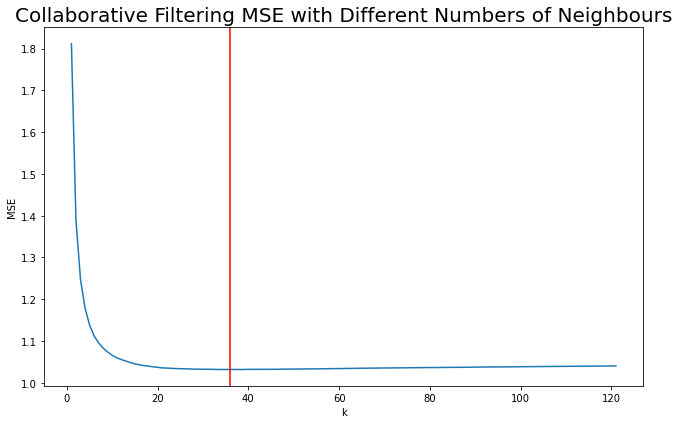

In [48]:
# metric_df.drop(columns=['type']).plot(x='k', y='mse')

filename = 'cf_grid_cv.png'
filepath = report_dir.joinpath('figures', filename)
plt.figure(figsize=(10,6))
plt.subplots_adjust(top=0.93)
plt.title('Collaborative Filtering MSE with Different Numbers of Neighbours', fontsize=20)
plt.xlabel('k')
plt.ylabel('MSE')
plt.tight_layout()
plt.plot(metric_df.k, metric_df.mse)
plt.axvline(x=36, color='r')
plt.savefig(filepath, dpi=300, bbox_incehes='tight')

plt.show()


The minimum MSE is achieved with `k=36` after which the MSE starts to increase again.

# Best Models

In [187]:
n_users = df_user.id_user.unique().shape[0]
n_items = df_user.movie_id.unique().shape[0]

colab_test_mse_list = []
ens_test_mse_list = []
mf_test_mse_list = []
n_factors = 162
iter_array = [198]
k = 36

pred_dict = {}

for i in range(5):
    run = i+1
    print(run)

    train = np.zeros((n_users, n_items))
    test = np.zeros((n_users, n_items))

    for row in df_user[df_user['Test_'+ str(run)] == 'Train'].itertuples():
       train[row[1]-1, row[4]-1] = row[2]

    for row in df_user[df_user['Test_'+ str(run)] != 'Train'].itertuples():
       test[row[1]-1, row[4]-1] = row[2]

    # Matrix Factorisation
    print(f'Matrix Factorisation')
    MF_SGD = ExplicitMF(train, n_factors, learning='sgd', verbose=True)
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
    mf_pred = MF_SGD.predictions
    pred_dict['mf'] = mf_pred

    # Colab Filter
    print(f'Collaborative Filtering')
    user_similarity = fast_similarity(train, kind='user')
    #     item_similarity = fast_similarity(train, kind='item')

    #     train_pred = predict_k(train, train, user_similarity, kind='user', k=k)
    user_pred = predict_k(test, train, user_similarity, kind='user', k=k)
    pred_dict['cf'] = user_pred


    mf_test_mse = np.sqrt(get_mse(mf_pred, test))
    colab_test_mse = np.sqrt(get_mse(user_pred, test))

    mf_test_mse_list += [mf_test_mse]
    colab_test_mse_list += [colab_test_mse]

    # Weighted ensemble
    # Take the reciprocal because the lower the mse the higher the weight
    colab_mse_recip = 1/colab_test_mse
    mf_mse_recip = 1/mf_test_mse
    ens_pred = (user_pred * colab_mse_recip + MF_SGD.predictions * mf_mse_recip)/(colab_mse_recip + mf_mse_recip)

    ens_test_mse_list += [np.sqrt(get_mse(ens_pred, test))]

1
Matrix Factorisation
Iteration: 198
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
Train mse: 0.5108034132154319
Test mse: 0.8499464662565807
Collaborative Filtering


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


2
Matrix Factorisation
Iteration: 198
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
Train mse: 0.515538153357333
Test mse: 0.826657932021423
Collaborative Filtering


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


3
Matrix Factorisation
Iteration: 198
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
Train mse: 0.5169815083702249
Test mse: 0.8209305698508699
Collaborative Filtering


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


4
Matrix Factorisation
Iteration: 198
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
Train mse: 0.5051275003690854
Test mse: 0.8248845692729803
Collaborative Filtering


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


5
Matrix Factorisation
Iteration: 198
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
Train mse: 0.5036603262146042
Test mse: 0.8201621581155513
Collaborative Filtering


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Evaluation

The average RMSE across the cross-validation sets step are printed here. The matrix factorisation method achieved the lowest RMSE at 0.92. Collaborative Filtering achieved 1.02 while the ensemble is in between at 0.94.

In [188]:
print(f'Average RMSE for Matrix Factorisation: {np.mean(mf_test_mse_list)}')
print(f'Average RMSE for Collaborative Filtering: {np.mean(colab_test_mse_list)}')
print(f'Aeragee RMSE for the Ensemble model: {np.mean(ens_test_mse_list)}')      

Average RMSE for Matrix Factorisation: 0.9102089038606875
Average RMSE for Collaborative Filtering: 1.015681415645414
Aeragee RMSE for the Ensemble model: 0.9271704339762767


In [189]:
print(mf_test_mse_list)
print(colab_test_mse_list)
print(ens_test_mse_list)

[0.9219254125234756, 0.9092073097052306, 0.9060521893637639, 0.908231561482522, 0.9056280462284454]
[1.0248095434410587, 1.0165329508693246, 1.0128658034610722, 1.0072815160603625, 1.0169172643952518]
[0.9378828420482103, 0.9260800127034857, 0.9228781724359193, 0.9226076621173452, 0.926403480576423]


## Matrix Factorization Classification Report and Confusion Matrix

In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


pred = np.round(MF_SGD.predictions[test.nonzero()].flatten(), 0)
actual = test[test.nonzero()].flatten()
print(classification_report(y_pred=pred,y_true=actual))
print("Confusion Matrix \n", confusion_matrix(y_pred=pred,y_true=actual))


              precision    recall  f1-score   support

         1.0       0.65      0.05      0.09      1391
         2.0       0.24      0.07      0.11      2192
         3.0       0.37      0.54      0.44      5182
         4.0       0.41      0.66      0.51      6778
         5.0       0.68      0.10      0.18      4457

    accuracy                           0.40     20000
   macro avg       0.47      0.29      0.27     20000
weighted avg       0.46      0.40      0.34     20000

Confusion Matrix 
 [[  65  327  750  245    4]
 [  21  157 1428  578    8]
 [  12  121 2812 2200   37]
 [   1   42 2061 4503  171]
 [   1   19  619 3354  464]]


## Collaborative Filtering Classification Report and Confusion Matrix

In [190]:
pred = np.round(user_pred[test.nonzero()].flatten(), 0)
actual = test[test.nonzero()].flatten()
print(classification_report(y_pred=pred,y_true=actual))
print("Confusion Matrix \n", confusion_matrix(y_pred=pred,y_true=actual))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.34      0.02      0.03      1158
         2.0       0.27      0.09      0.14      2377
         3.0       0.35      0.48      0.40      5477
         4.0       0.40      0.65      0.49      6820
         5.0       0.59      0.06      0.11      4168

    accuracy                           0.38     20000
   macro avg       0.33      0.22      0.20     20000
weighted avg       0.41      0.38      0.32     20000

Confusion Matrix 
 [[   0    0    0    0    0    0]
 [   9   19  208  639  279    4]
 [   3    6  224 1358  780    6]
 [  16   20  253 2611 2552   25]
 [   6   10  120 2106 4442  136]
 [   2    1   27  753 3134  251]]


C:\Users\Roger\.conda\envs\mdsi_deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Neural Networks

Using the features on each movie (release year and genre) combined with the features of the user that rated a movie (gender, state, occupation and age banding) a sparse matrix is built that is then fed into a neural network to predict ratings on unseen data.

## Data Collection

Firstly, get all movies and their attributes.  Create a year column for the year of release.

In [167]:
query = '''MATCH (m:MOVIE)
RETURN m'''
df = pd.DataFrame(graph.run(query).data())
df_movie = df.join(pd.DataFrame(df["m"].to_dict()).T)
df_movie = df_movie.drop('m', 1)
df_movie['year'] = pd.DatetimeIndex(df_movie['ReleaseDate']).year
df_movie.rename(columns={'id':'movie_id'}, 
                 inplace=True)
print(df_movie.shape)

(1682, 24)


Then get the User attributes.  The Zipcode is used to get the State code the user lives in.  The user-movie ratings have been split into 5 train/test splits of 80% train and 20% test and these splits were loaded into the RATED relationship.  They are included in the database query to be able to do cross validation.

In [168]:
query = '''
MATCH (u:USER)-[r:RATED]->(m:MOVIE), (u)-[:LIVES_IN]->(z:ZIPCODE)
RETURN 
u.id AS id_user, 
u.age as age, 
u.gender AS gender, 
u.occupation as occupation, 
z.State AS state,
r.rating AS rating, 
r.Test_1 as Test_1, 
r.Test_2 as Test_2, 
r.Test_3 as Test_3,
r.Test_4 as Test_4, 
r.Test_5 as Test_5, 
r.timestamp AS timestamp, 
m.id AS movie_id
'''
df_user_nn = pd.DataFrame(graph.run(query).data())
print(df_user.shape)

(100000, 92)


The ages for Users are grouped into age bands, so that similar users are across an age range rather than individual ages.

In [169]:
def age_band(df):
    if df['age'] <= 18:
        val = 'under_18'
    elif df['age'] > 18 and df['age'] <= 29:
        val = '18_to_29'
    elif df['age'] > 29 and df['age'] <= 39:
        val = '30_to_39'
    elif df['age'] > 39 and df['age'] <= 49:
        val = '40_to_49'
    elif df['age'] > 49 and df['age'] <= 59:
        val = '50_to_59'
    else:
        val = '60_and_over'
    return val

In [170]:
df_user_nn['age_band'] = df_user_nn.apply(age_band, axis=1)

Categorical features are turned into numeric values using 'one-hot encoding' to convert distinct values to separate columns.  For users this is done for:
- Occupation
- Gender
- State
- Age Band

For Movies, the same is applied to Year.

In [171]:
one_hot_o = pd.get_dummies(df_user_nn['occupation'])
one_hot_g = pd.get_dummies(df_user_nn['gender'])
one_hot_s = pd.get_dummies(df_user_nn['state'])
# one_hot_s = pd.get_dummies(df_user['zipcode'])
one_hot_a = pd.get_dummies(df_user_nn['age_band'])
# Drop column B as it is now encoded
df_user_nn = df_user_nn.drop('occupation',axis = 1)
df_user_nn = df_user_nn.drop('gender',axis = 1)
df_user_nn = df_user_nn.drop('state',axis = 1)
df_user_nn = df_user_nn.drop('age_band',axis = 1)
df_user_nn = df_user_nn.drop('age',axis = 1)
# Join the encoded df
df_user_nn = df_user_nn.join(one_hot_g)
df_user_nn = df_user_nn.join(one_hot_o)
df_user_nn = df_user_nn.join(one_hot_s)
df_user_nn = df_user_nn.join(one_hot_a)
df_user_nn.shape

(100000, 92)

In [172]:
one_hot_y = pd.get_dummies(df_movie['year'])
# Drop column B as it is now encoded
df_movie = df_movie.drop('year',axis = 1)
# Join the encoded df
df_movie = df_movie.join(one_hot_y)

Finally merge the User dataset with the Movie dataset to have 1 record per User-movie combination with the features of both combined.

In [173]:
df_user_movie = df_user_nn.merge(df_movie, on='movie_id', how='inner')#, rsuffix='_movie')
df_user_movie.shape

(100000, 185)

## Neural Network Processing

The Tensorflow architecture for Neural Network processing has been used.

In [176]:
# Placeholder for student's code (2 lines of code)
# Task: import the relevant packages and classes
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import LeakyReLU

tf.random.set_seed(168)
np.random.seed(168)

For neural networks, the input must be in a numpy array with:
- The actual value (rating) will be a separate array
- The array will then contain only numeric values so Title, ReleaseDate and IMBDURL are dropped from the movie attributes.  As well, movie id and user id are not to be part of the training as that would train for those specific combinations.  Timestamp and the Test Set indicators are dropped as these are not predictors of the rating.

In [91]:
def train_test_split(df_user_movie, TestSet):
    
    global X_train, X_test, y_train, y_test

    df_train = df_user_movie[df_user_movie['Test_' + str(TestSet)] == 'Train'] 
    df_test = df_user_movie[df_user_movie['Test_' + str(TestSet)] != 'Train']
    y_train = np.array(df_train["rating"])
    y_test = np.array(df_test["rating"])
    X_train = df_train.drop(['id_user', 'movie_id', 'Title', 
                                        'ReleaseDate', 'rating', 'timestamp',
                                        'IMDBURL', 'Test_1', 'Test_2', 'Test_3',
                            'Test_4', 'Test_5'], axis = 1).to_numpy()
    X_test = df_test.drop(['id_user', 'movie_id', 'Title', 
                                      'ReleaseDate', 'rating', 'timestamp', 
                                      'IMDBURL', 'Test_1', 'Test_2', 'Test_3',
                            'Test_4', 'Test_5'], axis = 1).to_numpy()
    
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

    return X_train, X_test, y_train, y_test 


## Training

Training is done on each cross-validation training/test split.  The RMSE for each run is saved and printed out for comparison at the end.

In [186]:
from sklearn.metrics import mean_squared_error

nn_test_mse_list = []
for TestRun in range(1, 6):
    print('Test Run {}'.format(TestRun))
    # Split the data into Train and Test depending on the Cross-Validation split
    X_train, X_test, y_train, y_test = train_test_split(df_user_movie, TestRun)

    # Build the model
    model = tf.keras.Sequential()

    model.add(Dense(100, activation='relu', input_shape=(173,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    # Set optimizer to Adam with mean squared error as the loss function
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    # Fit the training set
    history = model.fit(X_train, y_train, 
                       epochs=150, 
                       validation_split = 0.2,
                       batch_size=1000, 
                       verbose=False)

    # Predict ratings on the Test set for this cross-validation set and save the RMSE score
    nn_pred = model.predict(X_test,verbose=0)
    pred_dict['nn'] = nn_pred
    nn_test_mse = np.sqrt(mean_squared_error(nn_pred, y_test))
    nn_test_mse_list += [nn_mse]
    
print(f'Average RMSE is: {np.mean(nn_test_mse_list)}')

Test Run 1
Test Run 2
Test Run 3
Test Run 4
Test Run 5
Average RMSE is: 1.0517973688765163


In [184]:
nn_test_mse_list

[1.0517973688765163]

In [182]:
mf_pred.shape

(943, 1682)

In [95]:
np.mean(nn_test_mse)

1.027362497757327